## Wrangling Project: WeRateDogs

	WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. WeRateDogs has over 4 million followers and has received international media coverage.
	The goal of this paper is to make some insights about the provided data. In order to achieve this goal I will gather data from three different sources, identify quality and tidiness issues. Ways of fixing them will be defined in next chapter. In the last sections some insights about the data will be provided.

## Table of Contents
- [Gather](#gather)
- [Assessing](#assess)
- [Cleaning](#clean)
- [Analysis](#analysis)

### Introduction

	The project is based on three datasets.
	
	1. Twitter archive file contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which was used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo). Dataset contains 2356 tweets.
	
	2. Additional Data via the Twitter API. Retweet and favorite counts can be gathered by anyone from Twitter's API because the WeRateDogs Twitter archive contains the tweet IDs within it. I'm going to query Twitter's API to gather this valuable data.
	
	3. Image Predictions File. Udacity provides image classification data for every image in the WeRateDogs Twitter archive through a neural network. That can classify breeds of dogs. A table full of image predictions alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction.

Load nessecary packages

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import configparser
import json
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

<a id='gather'></a>
# Gather

Load twitter archive to df_1 and inspect first columns

In [2]:
df_1 = pd.read_csv('twitter-archive-enhanced.csv')

Download data from url and load to dataframe. The data contains neural network results.  
Show first few rows.

In [3]:
# Read data from url with requests package
url = r'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
content = requests.get(url)

# Split text by new lines and then by tabs
splitted_by_lines = content.text.split('\n')
splitted_by_tabs = [x.split('\t') for x in splitted_by_lines]

# Extract headers and data
headers = splitted_by_tabs[0]
data = splitted_by_tabs[1:]

# Create dataframe
df_2 = pd.DataFrame(data=data, columns=headers)

Write a function to query Twitter's API and save info to a file  
Read TOKENS and KEYS from configuration file and save data to tweet_json.txt


In [4]:
def get_tweet_data(ids, output_file='tweet_json.txt'):
    '''
    Query tweet data from Twitter's API

    Parameters
    ----------
    ids : list
        list of tweets ids
    output_file : str
        name of output file
    
    Returns
    -------
    fail_dict : dict
        dictionary with failed ids
    '''
    config = configparser.ConfigParser()
    config.read('twitter.cfg')

    auth = tweepy.OAuthHandler(config['API']['CONSUMER_KEY'], config['API']['CONSUMER_SECRET'])
    auth.set_access_token(config['API']['ACCESS_TOKEN'], config['API']['ACCESS_SECRET'])

    api = tweepy.API(auth)

    fail_dict = {}

    with open(output_file, 'w') as file:
        for idx in ids:
            try:
                response = api.get_status(idx)._json
                file.write(json.dumps(response)+'\n')
            except tweepy.TweepError as e:
                fail_dict[idx] = e
                pass
    return fail_dict

################################
# RUN BELLOW TWO LINES ONLY ONCE

# ids = df_1.tweet_id.values
# fails = get_tweet_data(ids)
################################

with open('tweet_json.txt') as file:
    data_text = file.read()

data = [json.loads(x) for x in data_text.split('\n')]

df_3 = pd.DataFrame.from_records(data)

<a id='assess'></a>
## Assessing

In [5]:
df_1.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
df_1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [8]:
df_1.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [9]:
df_1.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [10]:
# pd.set_option('max_colwidth', None)

# 23 tweets have other denominator than standard 10. Let's take a look at these outliers
df_1.loc[df_1.rating_denominator!=10, ['text','rating_denominator']].sort_values('rating_denominator')

#######################
### NOTES ON RATINGS
#######################
# Index  313: invalid scrapping. Should be 13/10 instead of 960/00
# Index 2335: invalid scrapping. Should be 9/10 instead of 1/2
# Index  784: invalid scrapping. Should be 14/10 instead of 9/11
# Index 1068: invalid scrapping. Should be 14/10 instead of 9/11
# Index 1662: invalid scrapping. Should be 10/10 instead of 9/11
# Index  342: invalid scrapping. no rating found in text.
# Index 1165: invalid scrapping. Should be 13/10 instead of 4/20
# Index 1202: invalid scrapping. Should be 11/10 instead of 50/50

,text,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,0
2335,This is an Albanian 3 1/2 legged Episcopalian...,2
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,7
784,"RT @dog_rates: After so many requests, this is...",11
1068,"After so many requests, this is Bretagne. She ...",11
1662,This is Darrel. He just robbed a 7/11 and is i...,11
342,@docmisterio account started on 11/15/15,15
1663,"I'm aware that I could've said 20/16, but here...",16
1165,Happy 4/20 from the squad! 13/10 for all https...,20
1598,Yes I do realize a rating of 4/20 would've bee...,20


In [11]:
# Some Rating contain float values

mask = df_1.text.str.contains("\d+\.\d+\/\d+")
df_1.loc[mask, ['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
45,This is Bella. She hopes her smile made you sm...,5,10
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
1689,I've been told there's a slight possibility he...,5,10
1712,Here we have uncovered an entire battalion of ...,26,10


In [12]:
df_1.describe(include=np.object)

,timestamp,source,text,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo
count,2356,2356,2356,181,2297,2356,2356,2356,2356,2356
unique,2356,4,2356,181,2218,957,2,2,2,2
top,2017-02-05 23:15:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Steve. He was just relaxing in hot tub...,2017-05-22 00:28:40 +0000,https://twitter.com/dog_rates/status/832369877...,None,None,None,None,None
freq,1,2221,1,1,2,745,2259,2346,2099,2326


In [13]:
# Most tweets was sent from iPhone
df_1.source.value_counts(normalize=True)

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     0.942699
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        0.038625
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     0.014007
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    0.004669
Name: source, dtype: float64

In [14]:
df_2.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True


In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2076 entries, 0 to 2075
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2076 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   object
 3   p1        2075 non-null   object
 4   p1_conf   2075 non-null   object
 5   p1_dog    2075 non-null   object
 6   p2        2075 non-null   object
 7   p2_conf   2075 non-null   object
 8   p2_dog    2075 non-null   object
 9   p3        2075 non-null   object
 10  p3_conf   2075 non-null   object
 11  p3_dog    2075 non-null   object
dtypes: object(12)
memory usage: 194.8+ KB


In [16]:
# Displays the same information as functions .count() and .nunique()
df_2.describe()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
count,2076,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075
unique,2076,2009,4,378,2006,2,405,2004,2,408,2006,2
top,758740312047005698,https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg,1,golden_retriever,0.556595,True,Labrador_retriever,0.0693617,True,Labrador_retriever,0.102595,True
freq,1,2,1780,150,2,1532,104,3,1553,79,2,1499


In [17]:
df_3.head(3)

,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,36435,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,31385,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,23648,False,False,False,False,en,NaN,NaN,NaN,NaN


In [18]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     950 non-null    object 
 1   id                             950 non-null    int64  
 2   id_str                         950 non-null    object 
 3   text                           950 non-null    object 
 4   truncated                      950 non-null    bool   
 5   entities                       950 non-null    object 
 6   extended_entities              549 non-null    object 
 7   source                         950 non-null    object 
 8   in_reply_to_status_id          33 non-null     float64
 9   in_reply_to_status_id_str      33 non-null     object 
 10  in_reply_to_user_id            33 non-null     float64
 11  in_reply_to_user_id_str        33 non-null     object 
 12  in_reply_to_screen_name        33 non-null     obj

In [19]:
df_3.describe()

,id,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,quoted_status_id
count,9.500000e+02,3.300000e+01,3.300000e+01,950.000000,950.000000,2.100000e+01
mean,8.081949e+17,8.180000e+17,4.760766e+16,4449.124211,12986.921053,8.364933e+17
std,5.431824e+16,5.391111e+16,1.908340e+17,5321.152405,14576.342986,3.786469e+16
min,6.660209e+17,6.670655e+17,1.185634e+07,1.000000,0.000000,7.591676e+17
25%,7.817352e+17,8.008580e+17,2.916630e+07,1761.500000,1729.750000,8.065709e+17
50%,8.138067e+17,8.320875e+17,1.582854e+09,3063.500000,9832.000000,8.413114e+17
75%,8.456077e+17,8.558181e+17,4.196984e+09,5310.000000,18664.750000,8.710758e+17
max,8.924206e+17,8.862664e+17,8.405479e+17,57139.000000,134097.000000,8.860534e+17


In [20]:
# 'Retweeted' column contains only False values
df_3.retweeted.unique()

array([False])

<a id='clean'></a>
# CLEANING



## **Quality issues**

#### DF_1 (twitter_archive data)
- Filter out retweets
- Drop useless columns
    - `source`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert to right data types
    - `tweet_id` -> str
    - `timestamp` -> datatime
- `rating_numerator` and `rating_denominator` should be left as their are. Six observations in the data has float rating which was extracted incorectly. I will fix it with **re** module. There is also some problems with scrapping algorithm which have to be fixed manually:

<table style="display: inline-block;text-align: center">
    <tr>
        <th>Index</th><th>True Value</th><th>Scrapped Value</th>
    </tr>
    <tr>
        <td>313</td><td>13/10</td><td>960/0</td>
    </tr>
    <tr>
        <td>2335</td><td>9/10</td><td>1/2</td>
    </tr>
    <tr>
        <td>784</td><td>14/10</td><td>9/11</td>
    </tr>
    <tr>
        <td>1068</td><td>14/10</td><td>9/11</td>
    </tr>
    <tr>
        <td>1662</td><td>10/10</td><td>9/11</td>
    </tr>
    <tr>
        <td>342</td><td>NaN</td><td>11/15</td>
    </tr>
    <tr>
        <td>1165</td><td>13/10</td><td>4/20</td>
    </tr>
    <tr>
        <td>1202</td><td>11/10</td><td>50/50</td>
</table>

#### DF_2 (neural network data)
- convert breeds into lowercase
- Convert columns to appropriate dtype
    - `p1_conf`, `p2_conf`, `p3_conf` --> float
- Drop useless columns
    - `jpg_url`, `img_num`
- Filter `p1`, `p2`, `p3`
    - Leave only breeds' names. They correspond to True values of columns **'p1_dog', 'p2_dog', 'p3_dog'**
    - Convert predicted breed names to lowercase. At the moment they have mixed lower and upper  cases
- Join to **master dataset** on `tweet_ids`
- `p1_dog`, `p2_dog` and `p3_dog` are in some cases not valid, e.g. `p1` prediction is 'orange' and `p1_dog` states is truly a dog's breed. I query wikipedia for a list of dog breed and check if dataset contains correct dog breeds.
- Drop columns `p1_dog`, `p2_dog` and `p3_dog` afterwards because they contain no useful value anymore.

#### DF_3 (twitter API data)
- No cleaning needed. I will use only tweet_id which is already string and two integer columns: `retqeet_count`, `favorite_count`.
- Join **df_3** to cleaned **df_1** dataframe on `tweet_ids`

## **Tidiness issues**

#### DF_1 (twitter_archive data)
- dog size falls in one of four columns `doggo`, `floofer`, `pupper`, `puppo`
    - first convert string 'None' value to represent real missing value.
    - there should be only one column `stage` with a size value. Function pd.melt will be handy.
    
#### DF_2 (neural network data)

In [21]:
# Make a copy of each dataframe to perform cleaning procedures

# Master dataframe will contain all columns for explanatory analysis
master_df = df_1.copy()
# Network dataframe contains predictions from neural network
pred_df = df_2.copy()
# Tweet dataframe contains favorite and retweets count for each tweet
tweet_df = df_3.copy()

In [22]:
# Remove retweets
retweets = df_1[~master_df.retweeted_status_id.isnull()].tweet_id.values
master_df = df_1[~master_df.tweet_id.isin(retweets)]

# TEST. Master dataframe should contain 181 rows less than original data
df_1.shape[0] - master_df.shape[0] == 181

True

In [23]:
# Drop columns
useless_columns = ['source','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls', 'in_reply_to_status_id','in_reply_to_user_id']
master_df = master_df.drop(useless_columns, axis=1)

# TEST
master_df.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [24]:
# Convert tweet_id to string
master_df.tweet_id = master_df.tweet_id.astype(str)
# Convert timestamp to datetime object
master_df.timestamp = pd.to_datetime(master_df.timestamp, format='%Y-%m-%d %H:%M:%S', )

# TEST
master_df[['tweet_id','timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweet_id   2175 non-null   object             
 1   timestamp  2175 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 51.0+ KB


In [25]:
# Make only one column for dogs' stage and drop old ones

# Convert string None in stage columns to real missing value
for col in master_df.columns[-4:]:
    master_df[col] = master_df[col].replace('None', np.nan)

# Create special melt function
def special_melt_function(row):
    """
    Take dogs' stages as columns and return it as row or return None if not provided
    """
    if row.isnull().all():
        return np.nan
    else:
        return row[~row.isnull()].values[0]
    
# Create new column 'stage' and drop old ones
master_df['stage'] = master_df.iloc[:,6:].apply(special_melt_function, axis=1)
master_df.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

# TEST
master_df.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage
116,870308999962521604,2017-06-01 16:00:09+00:00,"This is Rumble, but he's not ready to. Would r...",13,10,Rumble,NaN
1751,678991772295516161,2015-12-21 17:33:48+00:00,If your Monday isn't going so well just take a...,12,10,None,NaN
490,813812741911748608,2016-12-27 18:24:12+00:00,"Meet Gary, Carrie Fisher's dog. Idk what I can...",14,10,Gary,NaN
1267,709566166965075968,2016-03-15 02:25:31+00:00,This is Olaf. He's gotta be rare. Seems sturdy...,12,10,Olaf,NaN
1412,698953797952008193,2016-02-14 19:35:46+00:00,Meet CeCe. She wanted to take a selfie before ...,11,10,CeCe,NaN
534,807106840509214720,2016-12-09 06:17:20+00:00,This is Stephan. He just wants to help. 13/10 ...,13,10,Stephan,NaN
139,865359393868664832,2017-05-19 00:12:11+00:00,This is Sammy. Her tongue ejects without warni...,13,10,Sammy,NaN
1702,680934982542561280,2015-12-27 02:15:25+00:00,Say hello to Sadie. She's a Tortellini Sidewin...,10,10,Sadie,NaN
360,829861396166877184,2017-02-10 01:15:49+00:00,This is Mia. She already knows she's a good do...,12,10,Mia,NaN
2305,666837028449972224,2015-11-18 04:35:11+00:00,My goodness. Very rare dog here. Large. Tail d...,3,10,None,NaN


In [26]:
# Convert confidence intervals to floats
for col in pred_df.columns[pred_df.columns.str.contains('conf')]:
    pred_df[col] = pred_df[col].astype(float)

# Convert True/False columns to boolean type
for col in pred_df.columns[pred_df.columns.str.contains('dog')]:
    pred_df[col] = pred_df[col].astype(bool)

# TEST
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2076 entries, 0 to 2075
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2076 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   object 
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2076 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2076 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2076 non-null   bool   
dtypes: bool(3), float64(3), object(6)
memory usage: 152.2+ KB


In [27]:
# Drop useless columns
useless_columns = ['jpg_url','img_num']
pred_df.drop(useless_columns, axis=1, inplace=True)

# TEST. Should return empty set.
set(useless_columns) & set(pred_df.columns)

set()

In [28]:
# Get list of dog breed from wikipedia. Convert to a list
import wptools
import re

page = wptools.page('List_of_dog_breeds', silent=True).get()

text = page.data['wikitext']

breed_list_raw = text.split("\n")

breed_list = []


for row in breed_list_raw:
    item = re.findall("\[(.+)\]", row)
    breed_list.append(item)

new_list = []
for n, item in enumerate(breed_list[3:]):
    try:
        val = re.sub("\[|\]", "", item[0])
        vals = re.split("\|", val)
        new_list.extend(vals)
    except:
        pass
    
wiki_breeds = ["_".join(x.lower().split(" ")) for x in new_list]

# TEST
wiki_breeds[:15]

['affenpinscher',
 'afghan_hound',
 'aidi',
 'airedale_terrier',
 'akbash',
 'akita_(dog)',
 'akita',
 'alano_español',
 'alaskan_husky',
 'alaskan_klee_kai',
 'alaskan_malamute',
 'alpine_dachsbracke',
 'american_bulldog',
 'american_bully',
 'american_cocker_spaniel']

In [29]:
# Leave only correct breed's name and make None for everything else
# Also convert breed to lowercase

cols = ['p1','p2','p3']
for col in cols:
    pred_df[col] = np.where(pred_df[col+'_dog'], pred_df[col].str.lower(), np.nan)
    pred_df[col] = np.where(pred_df[col].isin(wiki_breeds), pred_df[col], np.nan)

# TEST
pred_df.head()

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,welsh_springer_spaniel,0.465074,True,NaN,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,NaN,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,rhodesian_ridgeback,0.408143,True,NaN,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,NaN,0.154629,True


In [30]:
# Create a new column containing the most probable breed

# write a funtions which return the most probable breed
# it maybe isn't the most efficient function but it works quite fast for this dataset.
def most_probable_breed(row):
    values = row[['p1_conf','p2_conf','p3_conf']].values
    keys = row[['p1','p2','p3']].values
    mapping = { key: value for key, value in zip(keys, values) if pd.notnull(key)}
    if len(mapping)==0:
        return np.nan, np.nan
    else:
        breed = max(mapping, key=mapping.get)
        probability = mapping[breed]
        return breed, probability

# Run function
pred_df[['pred_breed','pred_conf']] = pred_df.apply(most_probable_breed, axis=1, result_type='expand')

# Drop columns
pred_df.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1, inplace=True)

# TEST
pred_df.head()

,tweet_id,pred_breed,pred_conf
0,666020888022790149,welsh_springer_spaniel,0.465074
1,666029285002620928,miniature_pinscher,0.074192
2,666033412701032449,german_shepherd,0.596461
3,666044226329800704,rhodesian_ridgeback,0.408143
4,666049248165822465,miniature_pinscher,0.560311


In [31]:
# JOIN recognision dataframe to master on tweet_id
master_df = pd.merge(master_df, pred_df, on='tweet_id', how='left')

# TEST
master_df.shape

(2175, 9)

In [32]:
# Join tweet datafame to master
master_df = pd.merge(master_df, tweet_df[['id_str','retweet_count','favorite_count']], left_on='tweet_id', right_on='id_str', how='left', )
master_df.drop('id_str', axis=1, inplace=True)

# TEST
master_df.shape

(2175, 11)

In [33]:
# Save final dataset
master_df.to_csv('twitter_archive_master.csv', index=False)

# Show head of final dataaset
master_df.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,pred_breed,pred_conf,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,NaN,NaN,7747.0,36435.0
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,chihuahua,0.323581,5739.0,31385.0
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,chihuahua,0.716012,3799.0,23648.0
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,labrador_retriever,0.168086,7911.0,39751.0
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,NaN,NaN,8540.0,37958.0


<a id='analysis'></a>
### Storing, Analyzing, and Visualizing Data

- Morning, Day and night influence on favorites and retweets
- Which breeds have most favorites and retweets. Using available neural network data
- How likely users are favorite and retweet dogs. How likely dogs are shared and favorited

### Day time and most tweets and favorites


In [34]:
# Divide timestamp to four intervals. Each 6 hours:
# 0-6, 6-12, 12-18, 18-24
data_intervals = master_df.copy()
data_intervals.timestamp = data_intervals.timestamp.dt.tz_convert('US/Eastern')
hour = data_intervals.timestamp.dt.strftime("%H").astype(int)
interval = pd.interval_range(0, 24, 4, closed='left')
interval = np.arange(0, 25, 6)
data_intervals['period'] = pd.cut(hour, interval, labels=['night','morning','day','evening'], include_lowest=True, right=False)

# TEST
data_intervals.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,pred_breed,pred_conf,retweet_count,favorite_count,period
0,892420643555336193,2017-08-01 12:23:56-04:00,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,NaN,NaN,7747.0,36435.0,day
1,892177421306343426,2017-07-31 20:17:27-04:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,chihuahua,0.323581,5739.0,31385.0,evening
2,891815181378084864,2017-07-30 20:18:03-04:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,chihuahua,0.716012,3799.0,23648.0,evening
3,891689557279858688,2017-07-30 11:58:51-04:00,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,labrador_retriever,0.168086,7911.0,39751.0,morning
4,891327558926688256,2017-07-29 12:00:24-04:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,NaN,NaN,8540.0,37958.0,day


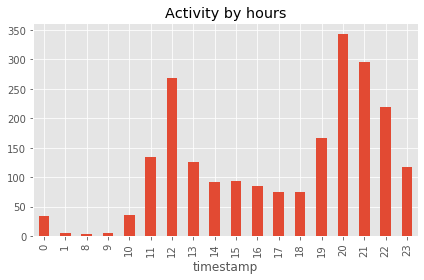

In [35]:
hour.groupby(hour).count().plot.bar()
plt.title("Activity by hours")
plt.tight_layout()
plt.savefig('figs/active_periods.png', dpi=300)

There is only 39 post during night period

In [36]:
data_intervals.groupby('period').tweet_id.count()

period
night        39
morning     179
day         738
evening    1219
Name: tweet_id, dtype: int64

And only one of them (index 445) has extremely favorite count

In [37]:
data_intervals[(data_intervals.period=='night')&(data_intervals.favorite_count.notnull())]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,pred_breed,pred_conf,retweet_count,favorite_count,period
106,869772420881756160,2017-05-31 00:27:59-04:00,"This is Dewey (pronounced ""covfefe""). He's hav...",13,10,Dewey,NaN,NaN,NaN,9431.0,40531.0,night
445,807106840509214720,2016-12-09 01:17:20-05:00,This is Stephan. He just wants to help. 13/10 ...,13,10,Stephan,NaN,chihuahua,0.505370,57139.0,121565.0,night
694,763956972077010945,2016-08-12 00:35:10-04:00,@TheEllenShow I'm not sure if you know this bu...,12,10,None,doggo,NaN,NaN,56.0,767.0,night
2101,667211855547486208,2015-11-19 00:24:37-05:00,This is Genevieve. She is a golden retriever c...,9,10,Genevieve,NaN,golden_retriever,0.462556,229.0,466.0,night


In [38]:
# Drop it
data_intervals.drop(445, inplace=True)

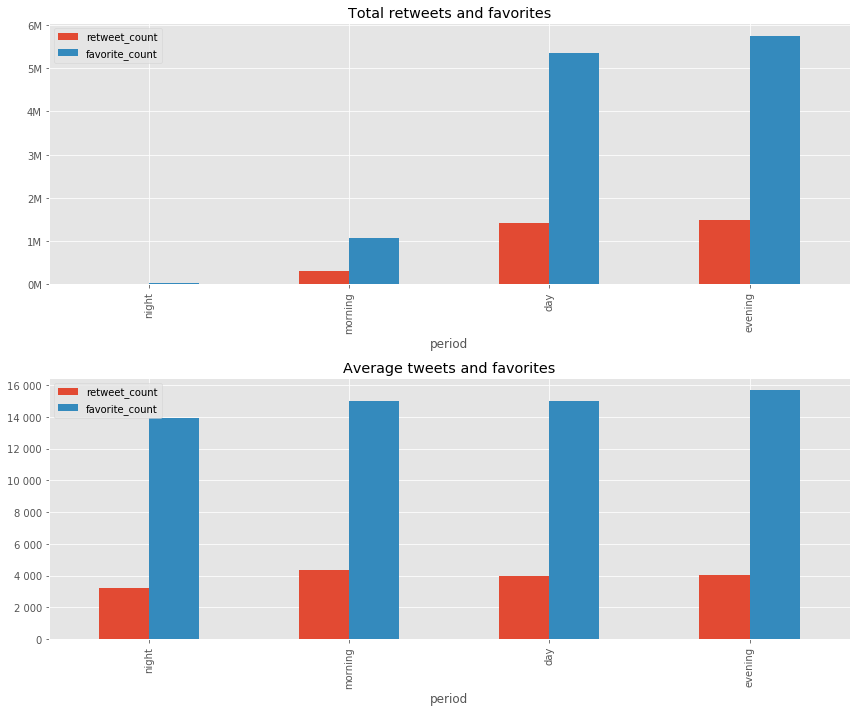

In [39]:
import matplotlib.ticker as mticker
plt.figure(figsize=(12,10))

ax=plt.subplot(2,1,1)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: "{:.0f}M".format(x/1000000)))
data_intervals.groupby('period')[['retweet_count','favorite_count']].sum().plot.bar(ax=ax)
ax.set_title("Total retweets and favorites")

ax=plt.subplot(2,1,2)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x).replace(","," ")))
data_intervals.groupby('period')[['retweet_count','favorite_count']].mean().plot.bar(ax=ax)
ax.set_title("Average tweets and favorites")

plt.tight_layout()
plt.savefig('figs/by_periods.png', dpi=300)

In [40]:
from scipy.stats import ttest_ind

sample1 = data_intervals.loc[data_intervals.period=='evening', 'favorite_count'].dropna()
sample2 = data_intervals.loc[data_intervals.period=='day', 'favorite_count'].dropna()

In [41]:
ttest_ind(sample1, sample2)

Ttest_indResult(statistic=0.6056305022264739, pvalue=0.5449504703306498)

T-test for two idependent samples confirms that there is no significant difference between day favorite_count and evening favorite_count

### Most favorited and retweeted breeds

In [42]:
# Drop rows without breed and with low prediction probability
popular_breeds = master_df[(master_df.pred_breed.notnull())&(master_df.pred_conf>=.2)].copy()
popular_breeds.shape

(1030, 11)

In [43]:
# Group by breeds, get mean and drop nan values
data = popular_breeds.groupby('pred_breed').favorite_count.mean().sort_values(ascending=False).dropna()

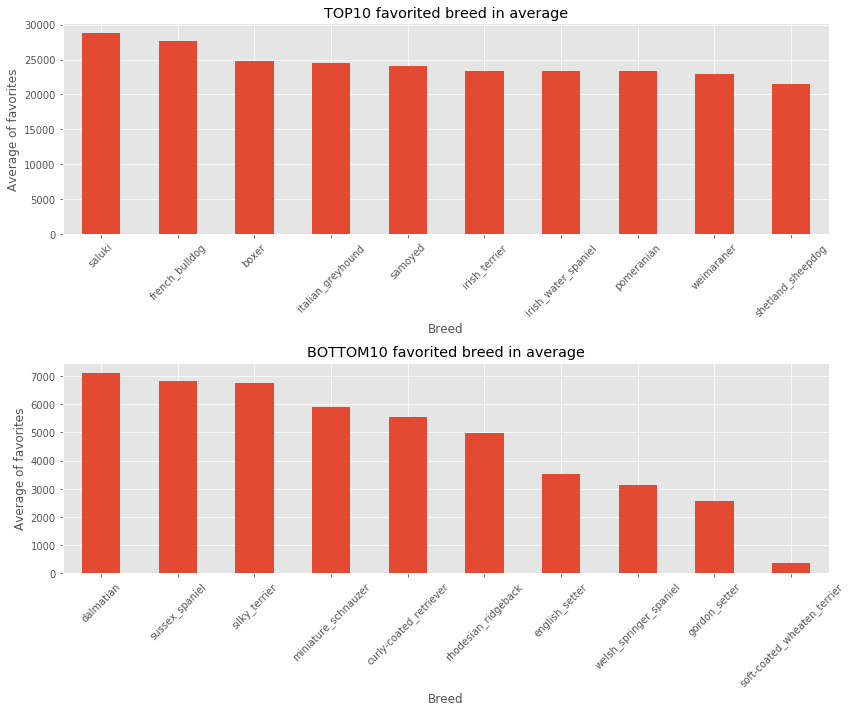

In [44]:
plt.figure(figsize=(12,10))

ax=plt.subplot(2,1,1)
data[:10].plot.bar(ax=ax, title="TOP10 favorited breed in average")
plt.xlabel("Breed")
plt.ylabel("Average of favorites")
plt.xticks(rotation=45)

ax=plt.subplot(2,1,2)
data[-10:].plot.bar(ax=ax, title="BOTTOM10 favorited breed in average")
plt.xlabel("Breed")
plt.ylabel("Average of favorites")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figs/top-breeds.png', dpi=300)

### Retweet vs. favorite

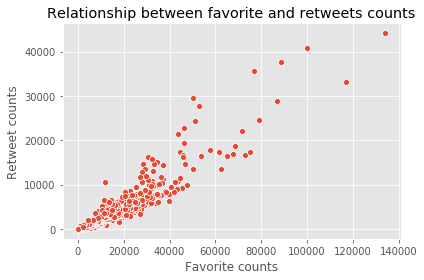

In [45]:
sns.scatterplot('favorite_count','retweet_count', data=data_intervals)

plt.tight_layout()
plt.title("Relationship between favorite and retweets counts")
plt.xlabel("Favorite counts")
plt.ylabel("Retweet counts")
plt.tight_layout()
plt.savefig('figs/retweets-vs-favorite.png', dpip=300)

In [46]:
print(data_intervals[['favorite_count','retweet_count']].corr().to_latex())

\begin{tabular}{lrr}
\toprule
{} &  favorite\_count &  retweet\_count \\
\midrule
favorite\_count &        1.000000 &       0.920676 \\
retweet\_count  &        0.920676 &       1.000000 \\
\bottomrule
\end{tabular}



Pearson's correlation coefficiant between both variables is linear and very strong.

***